In [1]:
!pip install pettingzoo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 816.1/816.1 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 24.0 MB/s eta 0:00:00


In [2]:
from pettingzoo.classic import connect_four_v3

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

# Using the PettingZoo environment

This notebook provides smalls chunks of code to get you started with the Connect4 project. You do not have to use this code in you final file, but you can if you wish to. 

In [4]:
env = connect_four_v3.env(render_mode="rgb_array")

env.reset()

# The main difference with the standard gym api is the way the environment is queried. The `step` method return `None`. To get the data on the environment, use the `last` method
state, reward, terminated, truncated, info = env.last()

# state is a dictionary with two keys: observation and action_mask
print(
    state["observation"].shape
)  # Observation is a numpy array with three coordinates, indicating the positions of the pieces of of player 0 and 1 on the the board
print(state["observation"][:, :, 0])  # Where the pieces of player 0 are
print(state["observation"][:, :, 1])  # Where the pieces of player 1 are

print(state["action_mask"])  # an array showing whether the actions are legal or nots


(6, 7, 2)
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[1 1 1 1 1 1 1]


In [5]:
env.reset()
env.step(0)

state, reward, terminated, truncated, info = env.last()

print(
    state["observation"].shape
) 
print(state["observation"][:, :, 0])  
print(state["observation"][:, :, 1])  

print(state["action_mask"])

(6, 7, 2)
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[1 1 1 1 1 1 1]


In [ ]:
np.transpose(state['observation'],(2,0,1)).shape

(2, 6, 7)

# Agents

Here are some implementations of trivial agents that you should be able to beat ultimately. 

In [6]:
class RandomPlayer:
    def __init__(self, rng=None):
        if rng is None:
            self.rng = np.random.default_rng()
        else:
            self.rng = rng

        self.name = "Random Player"

    def get_action(self, obs_mask, epsilon=None):
        return self.random_choice_with_mask(np.arange(7), obs_mask["action_mask"])

    def random_choice_with_mask(self, arr, mask):
        masked_arr = np.ma.masked_array(arr, mask=1 - mask)
        if masked_arr.count() == 0:
            return None
        return self.rng.choice(masked_arr.compressed())


In [7]:
class PlayLeftmostLegal:
    def __init__(self):
        self.name = "Left Player"

    def get_action(self, obs_mask, epsilon=None):
        for i, legal in enumerate(obs_mask["action_mask"]):
            if legal:
                return i
        return None


# Running a game


The following function runs a full game between the two agents. 

In [8]:
def play_game(env, agent0, agent1, display=False):
    done = False
    env.reset()
    obs, _, _, _, _ = env.last()
    while not done:
        for i, agent in enumerate([agent0, agent1]):
            action = agent.get_action(obs, epsilon=0)
            env.step(action)
            if display:
                clear_output(wait=True)
                plt.imshow(env.render())
                plt.show()
            obs, reward, terminated, _, _ = env.last()
            done = terminated
            if np.sum(obs["action_mask"]) == 0:
                if display: 
                    print('Draw')
                return 0.5
            if done:
                if display:
                    print(f"Player {i}: {agent.name} won")
                    print(obs['observation'][:, :, 0]- obs['observation'][:, :, 1])
                return i

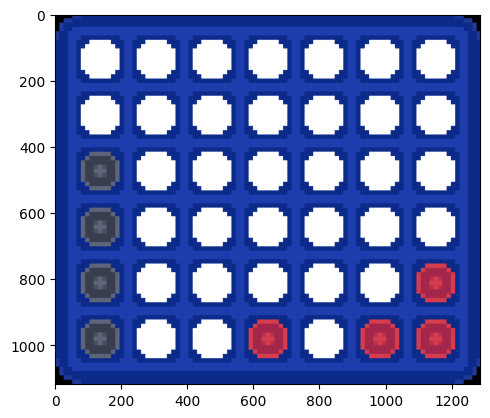

Player 1: Left Player won
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0 -1]
 [ 1  0  0 -1  0 -1 -1]]


1

In [18]:
agent0 = RandomPlayer()
agent1 = PlayLeftmostLegal()

play_game(env, agent0, agent1, display=True)

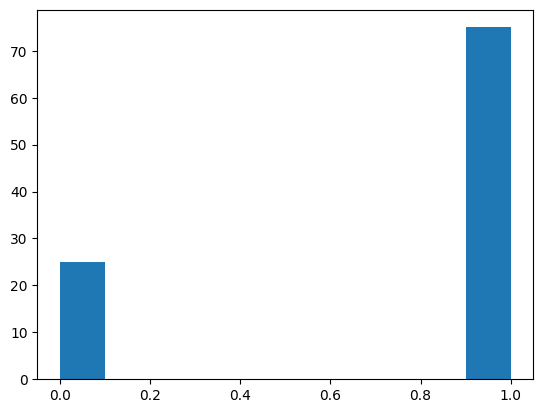

In [10]:
plt.hist([play_game(env, agent0, agent1, display=False) for _ in range(100)])
plt.show()

# Emulating a Gym environment

If we fix the opposite policy, the game from the point of view of the agent is equivalent to a Gym environment. The following class implements this simulation. Then any algorithm that would work in a gym environment with the same observations will work here. 

Note that we implemented the possibility to be the first or the second player. 

In [11]:
class EnvAgainstPolicy: 
    def __init__(self, env, policy, first_player=True):
        self.policy = policy
        self.env = env
        self.first_player = first_player
        self.reset()

    def step(self, action):
        self.env.step(action)
        obs, reward, terminated, _, _ = self.env.last()
        if terminated: 
            self.last_step = obs, reward, True, False, {}
        else: 
            action = self.policy.get_action(obs)
            self.env.step(action)
            obs, reward, terminated, _, _ = self.env.last()
            self.last_step = obs, -reward, terminated, False, {}
        return self.last_step

    def reset(self):
        self.env.reset()
        if not(self.first_player): 
            obs, _, _, _, _ = self.env.last()
            action = self.policy.get_action(obs)
            self.env.step(action)

        self.last_step = self.env.last()
        return self.last_step

    def last(self):
        return self.last_step

# Evaluating an agent against a fixed policy: 

Using the environment above, we can evaluate the agent against this fixed policy. 

In [12]:
def eval_against_policy(env, agent, policy, N_episodes=10, first_player=True):
    eval_env = EnvAgainstPolicy(env, policy, first_player=first_player)
    results = []
    for _ in range(N_episodes):
        done = False
        eval_env.reset()
        obs, _, _, _, _ = eval_env.last()
        while not done:
            action = agent.get_action(obs, epsilon=0)
            eval_env.step(action)
            obs, reward, done, _, _ = eval_env.last()
        results.append(reward)
    return results

We can see that if both players play randomly, there is a small but significant advantage to the first player. 

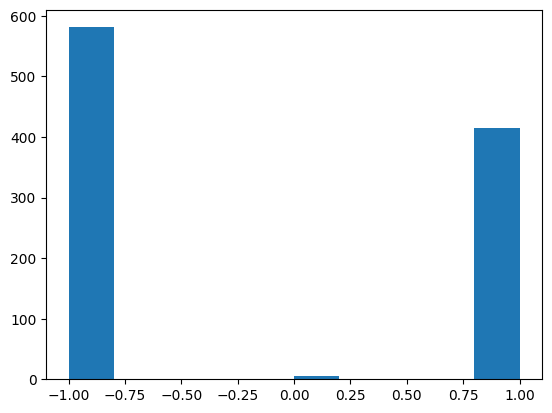

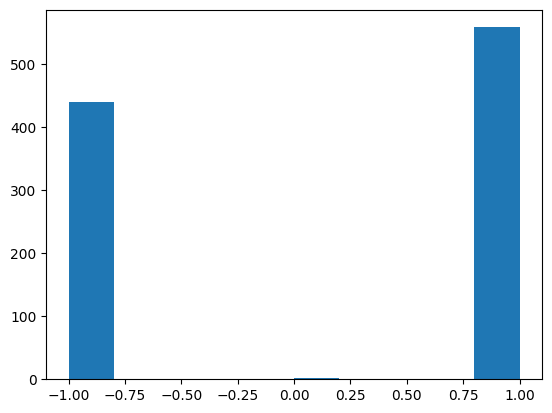

In [13]:
plt.hist(eval_against_policy(env, RandomPlayer(), RandomPlayer(), N_episodes=1000, first_player=False))
plt.show()
plt.hist(eval_against_policy(env, RandomPlayer(), RandomPlayer(), N_episodes=1000, first_player=True))
plt.show()

# Your turn 

Try to build a decent agent. Be creative! You can try any idea that you have: the grade is not about performance of the agent, but more about illustrating phenomena happening in Reinforcement Learning for turn-based games. It's okay to 'help' the agent in any way, as long as it follows the ideas of RL (i.e., as long as there is some learning involved).




## Defining DQN model

In [14]:
import random
import torch
from tqdm import tqdm
# Memory structure for DQN learning
class Memory:
    def __init__(self):
        self.reset()
        
    def __len__(self):
        return len(self.memory['done'])
    
    def reset(self):
        self.memory = {
            'observations' : [],
            'actions': [],
            'rewards': [],
            'done' : [],
            'next_observation': []
        }
    def add(self,obs,act,reward,done,next_obs):
        self.memory['observations'].append(obs)
        self.memory['actions'].append(act)
        self.memory['rewards'].append(reward)
        self.memory['done'].append(done)
        self.memory['next_observation'].append(next_obs)
        
    def get_mini_batch(self,size):
        if len(self) < size:
            return None
        else:
            inds = random.choices(range(len(self)), k=size)
            memo = {
                'observations': [self.memory['observations'][ind] for ind in inds],
                'actions': [self.memory['actions'][ind] for ind in inds],
                'rewards': [self.memory['rewards'][ind] for ind in inds],
                'done': [self.memory['done'][ind] for ind in inds],
                'next_observation': [self.memory['next_observation'][ind] for ind in inds]
            }
            return memo
                                  

In [15]:
# DQN model
class DQN: 
    def __init__(self, env, policy,batch_size=100,gamma = 1,tau=0.001):
        self.batch_size = batch_size
        self.policy = policy()
        self.tau = tau # tau << 1 in this case the problem is pure Markovian 
        self.target_policy = policy() # a copy to avoid divergence
        self.target_policy.load_state_dict(self.policy.state_dict())
        self.env = env
        self.gamma = gamma # gamma = 1 in this case (episodic case)
        self.memory = Memory()
        self.optimizer =  torch.optim.Adam(self.policy.parameters())
        self.obs = None
        self.action = None
        
    def step(self,action_free=True):
        state, _, terminated, _, _ = self.env.last()
        self.obs = np.transpose(state['observation'],(2,0,1))
        
        # SELECTS ACTION
        with torch.no_grad():
            result = self.policy(torch.Tensor(self.obs))
        if action_free:
            self.action = int(torch.argmax(result))
        else:
            ids= []
            for i,mask in enumerate(state['action_mask']):
                if mask ==1:
                    ids.append(i)
            ids_max = ids[0]
            for i in ids[1:]:
                if result[ids_max] < result[i]:
                    ids_max=  i
            self.action = ids_max
        return self.action
    def save(self,polarity=1):
        #COMPUTES ACTION
        if self.obs is None:
            return
        next_state, reward, terminated, _, _ = self.env.last()
        next_obs = np.transpose(next_state['observation'],(2,0,1))

        self.memory.add(self.obs,self.action,polarity*reward,terminated,next_obs)
        self.obs= None
        self.action = None

    def train(self):
        
        batch = self.memory.get_mini_batch(self.batch_size)
        
        if batch is None:
            return
        with torch.no_grad():
            y = torch.Tensor(batch['rewards']) + self.gamma*(1-torch.Tensor(batch['done']))*self.target_policy(torch.Tensor(batch['next_observation'])).max(dim=1).values
        
        model_y = self.policy(torch.Tensor(batch['observations'])).gather(dim=1, index=torch.tensor([[i] for i in batch['actions']]))
        
        # TRAINING
        loss = torch.nn.functional.mse_loss(y, model_y.squeeze())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # target_q_function = tau*q_function + (1-tau)*target_q_function
        for target_policy_param, policy_param in zip(self.target_policy.parameters(), self.policy.parameters()):
                    target_policy_param.data.copy_(
                        self.tau * policy_param.data + (1.0 - self.tau) * target_policy_param.data)

                
        return float(loss)


### Custom CNN based architecture (author: Rodolphe)

In [ ]:
# AI model Q-function
class CNN_pow4(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = torch.nn.Conv2d(2,64,4)
        self.conv_2 = torch.nn.Conv2d(64,16,(3,1))
        self.connect = torch.nn.Linear(4*16,7)

    def forward(self, x):
        #before : [2,6,7]
        x = self.conv(x) # [64,3,4]
        x = self.conv_2(x)# [16,1,4]
        x = torch.flatten(x,-3,-1) # [64]
        x = self.connect(x)# [7]
        return x


## Simulation environment

In [53]:
import time
def perso_player(env):
    time.sleep(0.5)
    return int(input('play: '))
    
    return end
def random_player(env):
    state, _, _, _, _ = env.last()
    mask = state['action_mask']
    list_id = []
    for i,mask in enumerate(mask):
        if mask:
            list_id.append(i)
    return random.sample(list_id,k=1)[0] 

def leftmost_player(env):
    state, _, _, _, _ = env.last()
    mask = state['action_mask']
    for i, legal in enumerate(mask):
        if legal:
            return i
    return None

def Game(env,model,player = 'random',train=False,show = True):
    S = 0
    i = 0
    player_one = random.randint(0,1)
    end = False  
    if player=='perso':
        pl = perso_player
    elif player == 'random':
        pl = random_player
    elif player == "leftmost":
        pl = leftmost_player
    model_win = False
    if player_one:
        while not end:
            
            action  = model.step()
            env.step(action)
            if show:
                clear_output(wait=True)
                plt.imshow(env.render())
                plt.show()
            
            _, _, end, _, _ = env.last()
            if not end:
                action = pl(env)
                env.step(action)
                _, _, end, trunc, _ = env.last()
                if show:
                    clear_output(wait=True)
                    plt.imshow(env.render())
                    plt.show()
                model.save(-1)
            else:
                model.save(1)
                model_win= end and not trunc
    else:
        while not end:
            action = pl(env)
            env.step(action)
            model.save(-1)
            if show:
                clear_output(wait=True)
                plt.imshow(env.render())
                plt.show()
            
            _, _, end, _, _ = env.last()
            
            if not end:
                action = model.step()
                env.step(action)
                _, _, end, trunc, _ = env.last()
                if show:
                    clear_output(wait=True)
                    plt.imshow(env.render())
                    plt.show()
                    
                if end:
                    model.save(1)
                    model_win= end and not trunc

    if show:    
        if player_one:
            print('model plays red')
        else:
            print('model plays black')
    return model_win

# Phase 1: custom CNN type model with training on random agent



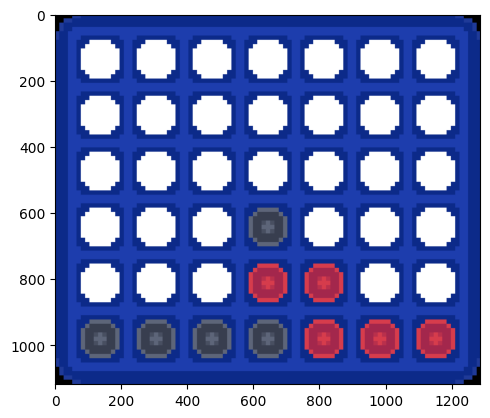

model plays blue


True

In [17]:
env = connect_four_v3.env(render_mode="rgb_array")

env.reset()
model = DQN(env,CNN_pow4)

nb_game  = 1000
nb_train_per_game = 10
pbar = tqdm(total= nb_game,desc=f'training games')
for i in range(nb_game):
    env.reset()
    Game(env,model,train=True,show=False)
    S=0
    for i in range(nb_train_per_game):
        s = model.train()
        if not s is None:
            S += s
            i += 1
    #pbar.set_postfix(loss=S/i)
    pbar.update(1)


## Inference

### Playing against random agent

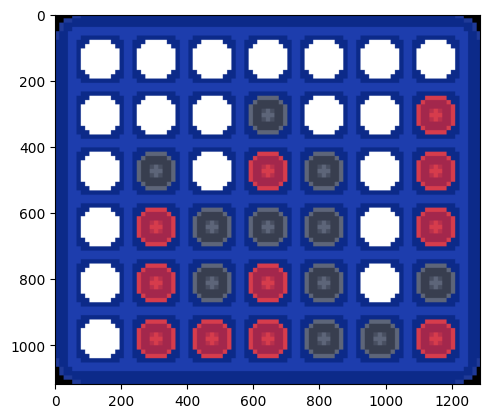

model plays red


False

In [33]:
env.reset()
Game(env,model,player="random")

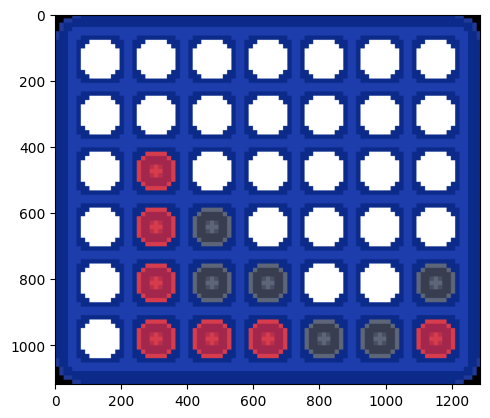

model plays red


True

In [34]:
env.reset()
Game(env,model,player="random")

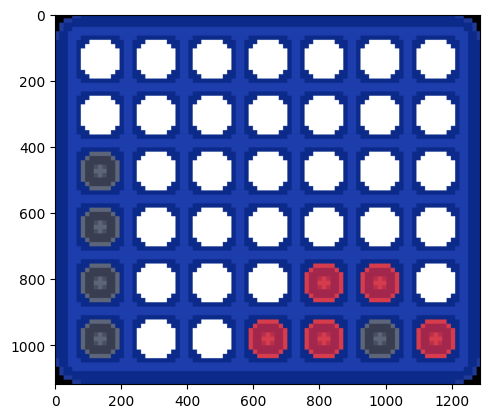

model plays black


True

In [35]:
env.reset()
Game(env,model,player="random")

### Playing against human

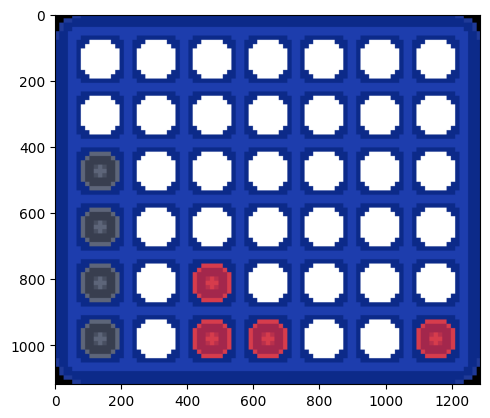

model plays red


False

In [36]:
env.reset()
Game(env,model, player="perso")

### Playing against leftmost player

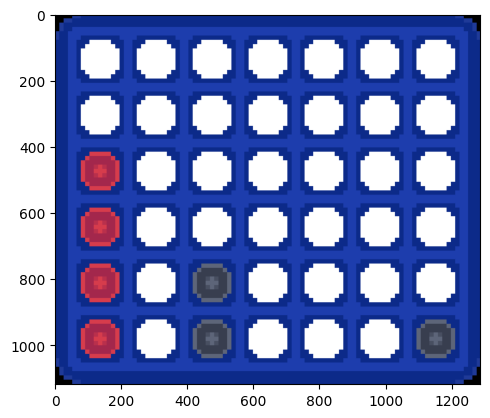

model plays black


False

In [62]:
env.reset()
Game(env,model, player="leftmost")

## Statistics

### Stats against random agent

In [50]:

def benchmark_random(n_games):
    
    win_rate = 0
    for i in tqdm(range(n_games)):
        env.reset()
        win = Game(env,model,player="random",show=False)
        win_rate += int(win)

    win_rate = win_rate/n_games

    print("{:.2f}".format(win_rate))
    return win_rate

In [52]:
benchmark_random(10000)


  0%|          | 0/10000 [00:00<?, ?it/s]WARNING:pettingzoo.utils.env_logger:[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
obs['action_mask'] contains a mask of all legal moves that can be chosen.

  1%|          | 70/10000 [00:00<00:57, 171.93it/s]WARNING:pettingzoo.utils.env_logger:[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
obs['action_mask'] contains a mask of all legal moves that can be chosen.

  1%|          | 124/10000 [00:00<00:57, 170.87it/s]WARNING:pettingzoo.utils.env_logger:[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
obs['action_mask'] contains a mask of all legal moves that can be chosen.
obs['action_mask'] contains a mask of all legal moves that can be chosen.

0.76


0.7605

### Stats against leftmost agent

In [63]:

def benchmark_leftmost(n_games):
    
    win_rate = 0
    for i in tqdm(range(n_games)):
        env.reset()
        win = Game(env,model,player="leftmost",show=False)
        win_rate += int(win)

    win_rate = win_rate/n_games

    print("{:.2f}".format(win_rate))
    return win_rate

In [64]:
benchmark_leftmost(10000)


100%|██████████| 10000/10000 [00:30<00:00, 330.96it/s]

0.00


0.0

# Phase 2: modifying training to allow wining against leftmost

One thing that can be seen is that, although the model performs well on average against a random player (meaning that our agent does better than randomly guessing), it consistently loses against a player that puts a coin to the left.

A first approach is to change the way our agent is trained, since for now we're only training against a random agent. Let's add iterations where it plays against a leftmost policy agent.

## Modifying training 

In [71]:
import random

env = connect_four_v3.env(render_mode="rgb_array")

env.reset()
model = DQN(env,CNN_pow4)

nb_game  = 1000
nb_train_per_game = 10
pbar = tqdm(total= nb_game,desc=f'training games')
for i in range(nb_game):
    env.reset()

    is_left = random.randint(0,1)
    if is_left:
      player = "leftmost"
    else:
      player = "random"

    Game(env,model,player=player,train=True,show=False)
    S=0
    for i in range(nb_train_per_game):
        s = model.train()
        if not s is None:
            S += s
            i += 1
    #pbar.set_postfix(loss=S/i)
    pbar.update(1)



training games:   0%|          | 0/1000 [00:00<?, ?it/s]WARNING:pettingzoo.utils.env_logger:[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
obs['action_mask'] contains a mask of all legal moves that can be chosen.
obs['action_mask'] contains a mask of all legal moves that can be chosen.

training games: 100%|██████████| 1000/1000 [2:05:22<00:00,  7.52s/it]
obs['action_mask'] contains a mask of all legal moves that can be chosen.
obs['action_mask'] contains a mask of all legal moves that can be chosen.
obs['action_mask'] contains a mask of all legal moves that can be chosen.
obs['action_mask'] contains a mask of all legal moves that can be chosen.
obs['action_mask'] contains a mask of all legal moves that can be chosen.
obs['action_mask'] contains a mask of all legal moves that can be chosen.
obs['action_mask'] contains a mask of all legal moves that can be chosen.

training games:   5

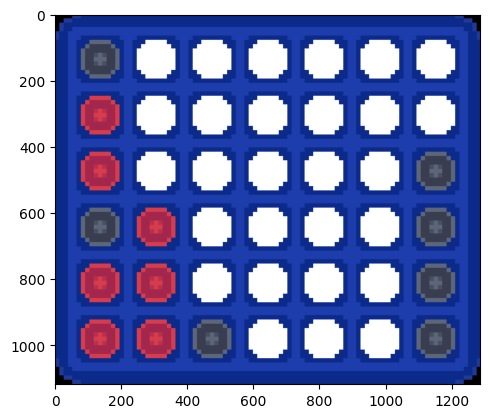

model plays black


True

In [74]:
env.reset()
Game(env,model, player="leftmost")

## Statistics

### Stats against random agent

In [75]:
benchmark_random(10000)

  0%|          | 24/10000 [00:00<00:44, 225.99it/s]WARNING:pettingzoo.utils.env_logger:[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
obs['action_mask'] contains a mask of all legal moves that can be chosen.
  0%|          | 47/10000 [00:00<00:52, 189.04it/s]WARNING:pettingzoo.utils.env_logger:[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
  1%|          | 70/10000 [00:00<00:48, 204.30it/s]WARNING:pettingzoo.utils.env_logger:[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
obs['action_mask'] contains a mask of all legal moves that can be chosen.
  1%|▏         | 137/10000 [00:00<00:45, 215.19it/s]WARNING:pettingzoo.utils.env_logger:[WARNING]: Illegal move made, game terminating with c

0.87


0.8689

### Stats against leftmost agent

In [76]:
benchmark_leftmost(10000)

100%|██████████| 10000/10000 [00:45<00:00, 221.68it/s]

1.00


1.0

# Phase 3: increasing training

We've now solved the problem for adressing an agent with a singular policy. Our agent also performs better against random agents, but we can still do better. One way to adress this would to increase the training iterations.

## Modifying training 

In [77]:
import random

env = connect_four_v3.env(render_mode="rgb_array")

env.reset()
model_v3 = DQN(env,CNN_pow4)

nb_game  = 10000
nb_train_per_game = 10
pbar = tqdm(total= nb_game,desc=f'training games')
for i in range(nb_game):
    env.reset()

    is_left = random.randint(0,1)
    if is_left:
      player = "leftmost"
    else:
      player = "random"

    Game(env,model_v3,player=player,train=True,show=False)
    S=0
    for i in range(nb_train_per_game):
        s = model_v3.train()
        if not s is None:
            S += s
            i += 1
    #pbar.set_postfix(loss=S/i)
    pbar.update(1)


training games:   0%|          | 0/10000 [00:00<?, ?it/s]WARNING:pettingzoo.utils.env_logger:[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
obs['action_mask'] contains a mask of all legal moves that can be chosen.
training games:   0%|          | 26/10000 [00:00<01:16, 130.67it/s]WARNING:pettingzoo.utils.env_logger:[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
training games:   0%|          | 40/10000 [00:01<08:47, 18.88it/s] WARNING:pettingzoo.utils.env_logger:[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
training games:   0%|          | 50/10000 [00:02<12:27, 13.31it/s]WARNING:pettingzoo.utils.env_logger:[WARNING]: Illegal move made, game terminating with current player losing. 

## Statistics

### Stats against random agent

In [78]:
def benchmark_random(n_games, model):
    
    win_rate = 0
    for i in tqdm(range(n_games)):
        env.reset()
        win = Game(env,model,player="random",show=False)
        win_rate += int(win)

    win_rate = win_rate/n_games

    print("{:.2f}".format(win_rate))
    return win_rate

In [79]:
benchmark_random(n_games = 10000, model = model_v3)


  5%|▍         | 453/10000 [00:02<00:49, 192.56it/s]WARNING:pettingzoo.utils.env_logger:[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.

  6%|▌         | 553/10000 [00:02<00:53, 177.74it/s]WARNING:pettingzoo.utils.env_logger:[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.

  9%|▊         | 872/10000 [00:04<00:55, 165.24it/s]WARNING:pettingzoo.utils.env_logger:[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.

 14%|█▍        | 1439/10000 [00:08<01:02, 136.34it/s]WARNING:pettingzoo.utils.env_logger:[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.

 15%|█▌        | 1519/10000 [00:09<01:08, 

0.94


0.9382

### Stats against leftmost agent

In [80]:
def benchmark_leftmost(n_games, model):
    
    win_rate = 0
    for i in tqdm(range(n_games)):
        env.reset()
        win = Game(env,model,player="leftmost",show=False)
        win_rate += int(win)

    win_rate = win_rate/n_games

    print("{:.2f}".format(win_rate))
    return win_rate

In [81]:
benchmark_leftmost(n_games = 10000, model=model_v3)


100%|██████████| 10000/10000 [00:39<00:00, 256.11it/s]

1.00


1.0

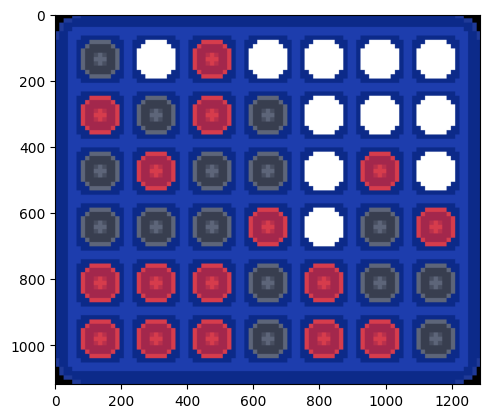

model plays black


False

In [82]:
env.reset()
Game(env,model_v3, player="perso")

# Phase 4: training against model

We now have an agent that performs very well against a random agent. However, we want to improve its performance even more. One way to do so would be to train a new against this trained model, and continue cyclically improving on from there.

### Modifying simulation parametrization

We need to modify the code so that it's able to accept custom models.

In [113]:
def Game_v2(env,model,ext_model,show = True):
    player_one = random.randint(0,1)
    end = False
    pl = ext_model
    model_win = False
    if player_one:
        while not end:
            
            action  = model.step()
            env.step(action)
            if show:
                clear_output(wait=True)
                plt.imshow(env.render())
                plt.show()
            
            _, _, end, _, _ = env.last()
            if not end:
                action = pl.step()
                env.step(action)
                _, _, end, trunc, _ = env.last()
                if show:
                    clear_output(wait=True)
                    plt.imshow(env.render())
                    plt.show()
                model.save(-1)
            else:
                model.save(1)
                model_win= end and not trunc
    else:
        while not end:
            action = pl.step()
            env.step(action)
            model.save(-1)
            if show:
                clear_output(wait=True)
                plt.imshow(env.render())
                plt.show()
            
            _, _, end, _, _ = env.last()
            
            if not end:
                action = model.step()
                env.step(action)
                _, _, end, trunc, _ = env.last()
                if show:
                    clear_output(wait=True)
                    plt.imshow(env.render())
                    plt.show()
                    
                if end:
                    model.save(1)
                    model_win= end and not trunc

    if show:    
        if player_one:
            print('model plays red')
        else:
            print('model plays black')
    return model_win

In [129]:
import random

env = connect_four_v3.env(render_mode="rgb_array")

env.reset()
model_zero = DQN(env,CNN_pow4)

nb_game  = 20000
nb_train_per_game = 10
pbar = tqdm(total= nb_game,desc=f'training games')
for i in range(nb_game):
    env.reset()

    Game_v2(env,model_zero,ext_model=model_v3,show=False)
    for i in range(nb_train_per_game):
        model_zero.train()
    #pbar.set_postfix(loss=S/i)
    pbar.update(1)


Streaming output truncated to the last 5000 lines.
training games:  88%|████████▊ | 17518/20000 [54:55<09:15,  4.47it/s]WARNING:pettingzoo.utils.env_logger:[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.

training games:  88%|████████▊ | 17520/20000 [54:56<08:51,  4.66it/s]WARNING:pettingzoo.utils.env_logger:[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.

training games:  88%|████████▊ | 17521/20000 [54:56<08:43,  4.73it/s]WARNING:pettingzoo.utils.env_logger:[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.

training games:  88%|████████▊ | 17523/20000 [54:56<08:29,  4.86it/s]WARNING:pettingzoo.utils.env_logger:[WARNING]: Illegal move made, game terminating with current player losing. 


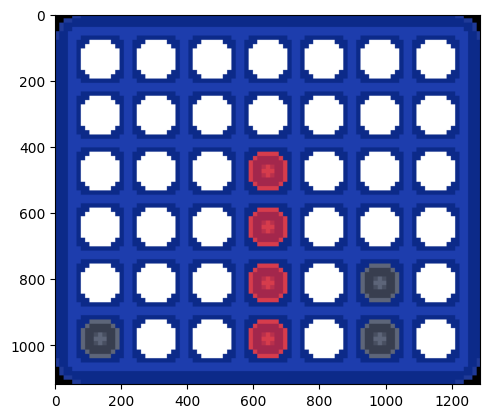

model plays red


True

In [133]:
env.reset()
Game(env,model_zero, player="random")

# Analyzing agent behavior

(array([19247.,  3435.,     0., 21428.,     0., 12430.,  1338.,     0.,
          882., 66421.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

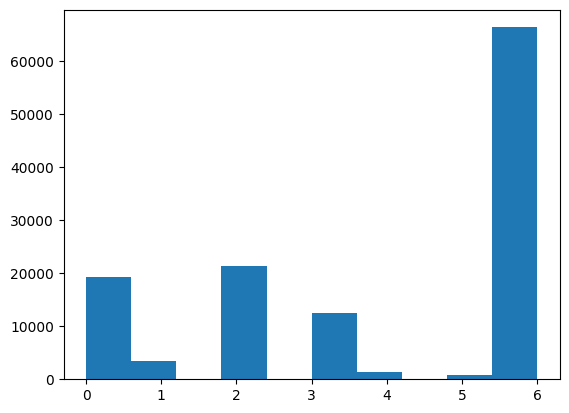

In [136]:
# Phase 2

import matplotlib.pyplot as plt
plt.hist(model.memory.memory['actions'])

(array([17620., 14509.,     0., 12286.,     0., 79711., 15134.,     0.,
        18993., 23073.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

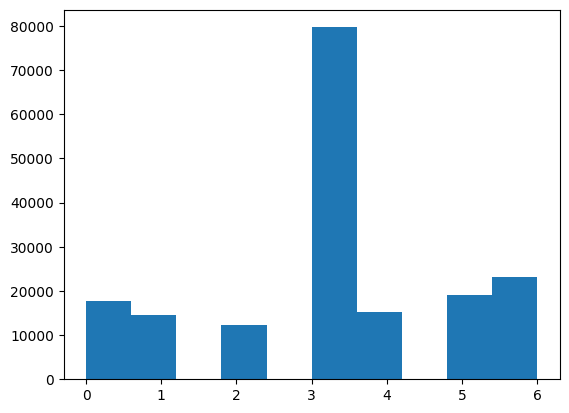

In [135]:
# Phase 3

import matplotlib.pyplot as plt
plt.hist(model_v3.memory.memory['actions'])

(array([1.6000e+01, 1.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        6.0388e+04, 1.0000e+01, 0.0000e+00, 1.3000e+01, 2.9541e+04]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

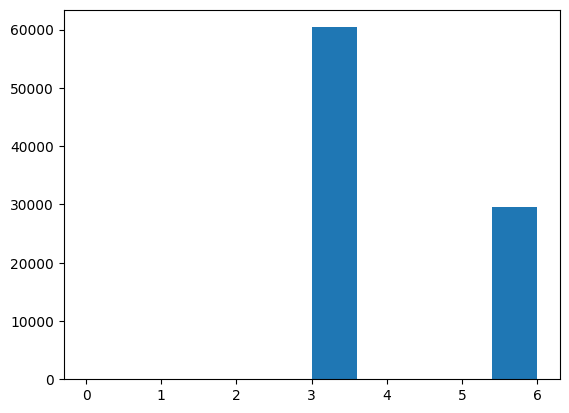

In [134]:
# Phase 4

import matplotlib.pyplot as plt
plt.hist(model_zero.memory.memory['actions'])